<a href="https://colab.research.google.com/github/lingmHVAC/lingmHVAC/blob/main/5_10_min_beta_optimize_2pt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


CALIBRATED PARAMETERS (two-interval)
Window 0-150: J1=6.886 #/cm3/s, C1=0.000000 µm/s, beta1=1.03e-04 s^-1 µm^-2
Window 150-300: J2=8.306 #/cm3/s, C2=0.000000 µm/s, beta2=1.32e-04 s^-1 µm^-2
K multiplier=1.000e+03 (Brownian kernel scale)


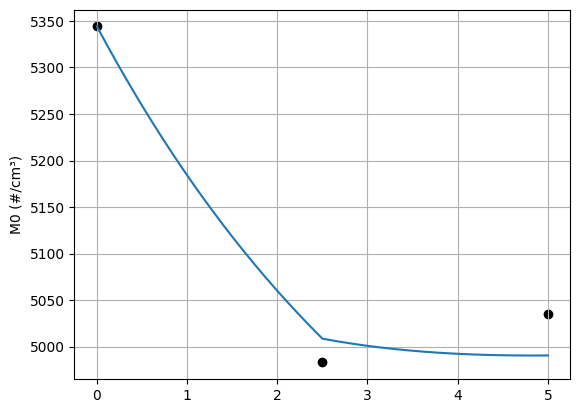

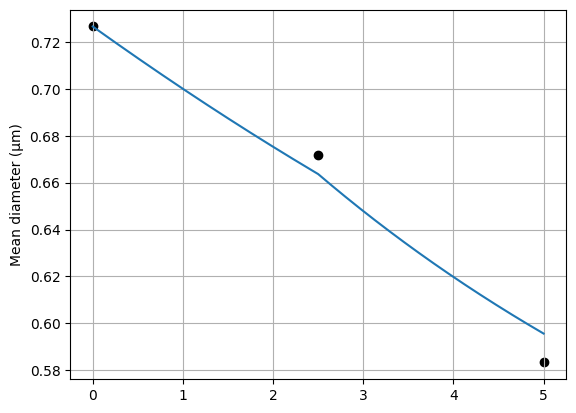

In [2]:
# All models with physical sedimentation
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
# last modified January 12, 2026
# This code splits an experimental interval 0-300 seconds for
# which we have expt M0-M3 into two intervals 0-150 sec and
# 150s- 300 sec. It seeks to find the J1, C1, J2, C2, K, beta1, beta2
# that best satisfy the expt moments at 0, 150, and 300 sec.
# J is the nucleation flux, C is the surface growth, K is
# the Brownian agglomeration factor, and beta is the sedimentation param.
# I asked gemini to allow beta to be optimized in two intervals
# which significantly improved the predictions.
# I also asked for a post-processing step which plots the sources for
# each moment to better understand what the drivers are for the matches
# In this code, the surface growth is a power law form
#    dM0 = nuc0 + gr0 + co0 + sed0
#    dM1 = nuc1 + gr1 + co1 + sed1
#    dM2 = nuc2 + gr2 + co2 + sed2
#    dM3 = nuc3 + gr3 + co3 + sed3
# I use a weight factor array to help weight the matching to
# particular moments.
# weight vector for [M0, M1, M2, M3]. I get pretty good results
# with  w = np.array([3.0, 2.0, .1, 2.0])
# ============================================================
# SYSTEM GEOMETRY & PHYSICS
# ============================================================
rho_p = 1000      # kg/m3
rho_g = 1.2       # kg/m3
mu = 1.8e-5       # Pa s
g = 9.81          # m/s2
H = .3          # m  <-- effective chamber height
# ============================================================
# SURFACE GROWTH MODEL
# dd/dt = Cg * d^m_g  (d in µm, Cg in µm^(1-m_g)/s)
# Set m_g = 0.0 to recover your current "constant growth rate" model.
# ============================================================
m_g = -1.0   # <-- change this to explore power-law growth (e.g., -1.0, 0.5, 1.0)

# beta = (rho_p - rho_g) * g / (18 * mu * H)
# beta *= 1e-12     # convert to s^-1 µm^-2

# ============================================================
# APS MEASUREMENTS
# ============================================================
t_data = np.array([0, 150, 300])
#The data below is 5.7 min to 10.033 min
M_data = np.array([
    [5344, 3883, 5575, 21578],
    [4983, 3347, 4061, 13608],
    [5035, 2937, 2860, 8382]
])

#The data below is 10.033 min, 12.533 ,15.033 min
#M_data = np.array([
#   [5035, 2937, 2860, 8382],
#    [6091.68, 3135.418, 2553.06, 7743.80],
#    [6734.9, 3270.82, 2438.96, 8130.70]
#])

din = 0.3  # µm

# ============================================================
# QMOM (2-node)
# ============================================================
#def qmom_nodes(M):
#    M0, M1, M2, M3 = M
#    mu_d = M1 / M0
#    var = max(M2 / M0 - mu_d**2, 1e-12)
#    std = np.sqrt(var)
#    return 0.5*M0, mu_d - std, 0.5*M0, mu_d + std

def qmom_nodes(M, eps_var=1e-18, Dmin=1e-30):
    """
    Two-node QMOM (Gaussian quadrature) reconstruction from moments M0..M3.

    Returns: (w1, D1, w2, D2) such that
        M_k ≈ w1*D1**k + w2*D2**k for k=0..3

    Notes:
      - Requires M0>0 and realizable moments; if variance is tiny, returns a
        degenerate 1-node quadrature: w1=M0, D1=mu1, w2=0, D2=mu1.
      - Clamps diameters to Dmin to avoid negative/zero nodes.
    """
    M0, M1, M2, M3 = M
    if M0 <= 0.0:
        return 0.0, Dmin, 0.0, Dmin

    # normalized moments
    mu1 = M1 / M0
    mu2 = M2 / M0
    mu3 = M3 / M0

    # variance-like term
    b1 = mu2 - mu1**2
    if b1 <= eps_var:
        D = max(mu1, Dmin)
        return float(M0), float(D), 0.0, float(D)

    a0 = mu1
    a1 = (mu3 - 2.0*mu1*mu2 + mu1**3) / b1

    # Solve for eigenvalues of 2x2 Jacobi matrix:
    # x^2 - (a0+a1)x + (a0*a1 - b1) = 0
    trace = a0 + a1
    det = a0*a1 - b1
    disc = trace*trace - 4.0*det
    disc = max(disc, 0.0)
    sqrt_disc = np.sqrt(disc)

    D1 = 0.5*(trace - sqrt_disc)
    D2 = 0.5*(trace + sqrt_disc)

    # enforce ordering and positivity
    D1 = max(D1, Dmin)
    D2 = max(D2, D1*(1.0 + 1e-12))

    # weights from M0 and M1
    # w1 + w2 = M0
    # w1*D1 + w2*D2 = M1
    denom = (D2 - D1)
    # Avoid division by zero if D1 and D2 become too close despite clamping
    if denom == 0.0:
        return 0.0, Dmin, 0.0, Dmin # Or handle as an error condition
    w1 = M0 * (D2 - mu1) / denom
    w2 = M0 * (mu1 - D1) / denom

    # small numerical cleanup
    if w1 < 0 and abs(w1) < 1e-12:
        w1 = 0.0
    if w2 < 0 and abs(w2) < 1e-12:
        w2 = 0.0

    return float(w1), float(D1), float(w2), float(D2)


# ============================================================
# MOMENT ODEs
# ============================================================
#def coag_source_qmom(k, K, w1, d1, w2, d2):
#    Ds = np.array([d1, d2], dtype=float)
#    Ws = np.array([w1, w2], dtype=float)
#    s = 0.0
#    for i in range(2):
#        for j in range(2):
#            di, dj = Ds[i], Ds[j]
#            wi, wj = Ws[i], Ws[j]
#            dp = np.cbrt(di**3 + dj**3)   # robust real cube root
#            s += (dp**k - di**k - dj**k) * wi * wj
#    return 0.5 * K * s

kB = 1.380649e-23  # J/K


# K_brownian_continuum_cm3s(di_um, dj_um, T=298.0, mu_g=1.8e-5):
def K_brownian_continuum(di, dj, T=298.0, mu_g=1.8e-5):
    di = max(di, 1e-30)
    dj = max(dj, 1e-30)
    return 1e6*(2.0 * kB * T / (3.0 * mu_g)) * ( (1.0/di + 1.0/dj) * (di + dj) )

#K=Kmult
def coag_source_qmom(k, K, w1, d1, w2, d2):
    T=298.0
    mu_g=1.8e-5
    Ds = np.array([d1, d2], dtype=float)
    Ws = np.array([w1, w2], dtype=float)
    s = 0.0
    for i in range(2):
        for j in range(2):
            di, dj = Ds[i], Ds[j]
            wi, wj = Ws[i], Ws[j]
            Kij = K * K_brownian_continuum(di, dj, T=T, mu_g=mu_g)
            dp = np.cbrt(di**3 + dj**3)
            s += Kij * (dp**k - di**k - dj**k) * wi * wj
    return 0.5 * s

#def moment_rhs(t, y, Jin, Cg, K):
#    M0, M1, M2, M3 = y
#    M0 = max(M0, 1e-9)
#
#    w1, d1, w2, d2 = qmom_nodes(y)
#    M4 = w1*d1**4 + w2*d2**4
#    M5 = w1*d1**5 + w2*d2**5
#
#    dM0 = Jin - 0.5*K*M0**2 - beta*M2
#    dM1 = Jin*din + Cg*M0 - beta*M3
#    dM2 = Jin*din**2 + 2*Cg*M1 + K*M1**2 - beta*M4
#    dM3 = Jin*din**3 + 3*Cg*M2 + 3*K*M1*M2 - beta*M5
#
#    return [dM0, dM1, dM2, dM3]

def moment_rhs(t, y, Jin, Cg, K, beta_val):
    M0, M1, M2, M3 = y
    M0 = max(M0, 1e-12)

    w1, d1, w2, d2 = qmom_nodes(y)

    # higher moments for sedimentation sink
    M4 = w1*d1**4 + w2*d2**4
    M5 = w1*d1**5 + w2*d2**5

    # --- nucleation contributions ---
    nuc0 = Jin
    nuc1 = Jin * din
    nuc2 = Jin * din**2
    nuc3 = Jin * din**3

    # --- growth contributions (this assumes G_d is constant = Cg) ---
    # If your growth is actually m=-1 etc, change these accordingly.
    #gr0 = 0.0
    #gr1 = Cg * M0
    #gr2 = 2.0 * Cg * M1
    #gr3 = 3.0 * Cg * M2

    # --- growth contributions: dd/dt = Cg * d^m_g ---
    # Moment identity: dM_k/dt|growth = k * Cg * M_{k-1+m_g}
    # Evaluate M_p using QMOM nodes, so it works for fractional/negative p too.
    d_floor = 1e-30  # prevents division by zero if m_g < 0

    def Mp(p):
        return w1 * max(d1, d_floor)**p + w2 * max(d2, d_floor)**p

    gr0 = 0.0
    gr1 = 1.0 * Cg * Mp(m_g)           # k=1 -> p = 0 + m_g
    gr2 = 2.0 * Cg * Mp(1.0 + m_g)     # k=2 -> p = 1 + m_g
    gr3 = 3.0 * Cg * Mp(2.0 + m_g)     # k=3 -> p = 2 + m_g


    # --- coagulation contributions via QMOM closure ---
    co0 = coag_source_qmom(0, K, w1, d1, w2, d2)
    co1 = coag_source_qmom(1, K, w1, d1, w2, d2)
    co2 = coag_source_qmom(2, K, w1, d1, w2, d2)
    co3 = coag_source_qmom(3, K, w1, d1, w2, d2)

    # --- sedimentation sinks ---
    sed0 = -beta_val * M2
    sed1 = -beta_val * M3
    sed2 = -beta_val * M4
    sed3 = -beta_val * M5

    dM0 = nuc0 + gr0 + co0 + sed0
    dM1 = nuc1 + gr1 + co1 + sed1
    dM2 = nuc2 + gr2 + co2 + sed2
    dM3 = nuc3 + gr3 + co3 + sed3

    # Check for NaN/Inf values before returning
    result = np.array([dM0, dM1, dM2, dM3])
    if not np.all(np.isfinite(result)):
        # If any element is NaN or Inf, return a large error array
        # This helps the optimizer to move away from problematic regions.
        return np.full_like(result, np.inf)

    return result

def integrate_window(t0, t1, y0, Jin, Cg, K, beta_val):
    sol = solve_ivp(
        lambda t, y: moment_rhs(t, y, Jin, Cg, K, beta_val),
        (t0, t1),
        y0,
        t_eval=[t1],        # only need the endpoint
        method="BDF",
        rtol=1e-8,
        atol=1e-10
    )
    if (not sol.success) or np.any(~np.isfinite(sol.y)):
        return None
    return sol.y[:, -1]     # state at t1


def rel_residual(model, data):
    denom = np.maximum(np.abs(data), 1.0)
    return (model - data) / denom

def integrate_endpoint(t0, t1, y0, Jin, Cg, K, beta_val):
    """
    Integrate moment ODEs from t0 to t1 and return the state at t1.
    Used for two-interval calibration.
    """
    sol = solve_ivp(
        lambda t, y: moment_rhs(t, y, Jin, Cg, K, beta_val),
        (t0, t1),
        y0,
        t_eval=[t1],          # only need endpoint
        method="BDF",         # stiff-safe
        rtol=1e-8,
        atol=1e-10
    )

    if (not sol.success) or np.any(~np.isfinite(sol.y)):
        return None

    return sol.y[:, -1]      # shape (4,)


def residuals_two_interval(params):
    J1, C1, J2, C2, K, beta1, beta2 = params

    y150_model = integrate_endpoint(0.0, 150.0, M_data[0], J1, C1, K, beta1)
    if y150_model is None:
        return 1e6*np.ones(8)

    y300_model = integrate_endpoint(150.0, 300.0, y150_model, J2, C2, K, beta2)
    if y300_model is None:
        return 1e6*np.ones(8)

    y150_data = M_data[1]
    y300_data = M_data[2]

    r150 = (y150_model - y150_data) / np.maximum(np.abs(y150_data), 1.0)
    r300 = (y300_model - y300_data) / np.maximum(np.abs(y300_data), 1.0)

    # weight vector for [M0, M1, M2, M3]
    w = np.array([1.0, 1.0, 1., 1.0])

    r150 *= w
    r300 *= w

    return np.hstack([r150, r300])


# def residuals_two_interval(params):
#     J1, C1, J2, C2, K = params

#     y0 = M_data[0]               # state at t=0
#     y150_target = M_data[1]      # data at t=150
#     y300_target = M_data[2]      # data at t=300

#     # integrate 0 -> 150 using window 1 params
#     y150_model = integrate_window(0.0, 150.0, y0, J1, C1, K)
#     if y150_model is None:
#         return 1e6 * np.ones(8)  # 4 moments at 150 + 4 moments at 300

#     # integrate 150 -> 300 using window 2 params, starting from model state at 150
#     y300_model = integrate_window(150.0, 300.0, y150_model, J2, C2, K)
#     if y300_model is None:
#         return 1e6 * np.ones(8)

#     r150 = rel_residual(y150_model, y150_target)
#     r300 = rel_residual(y300_model, y300_target)

#     return np.hstack([r150, r300])

# ============================================================
# CALIBRATION
# ============================================================
#def residuals(params):
#    Jin, Cg, K = params
#    sol = solve_ivp(
#        lambda t, y: moment_rhs(t, y, Jin, Cg, K),
#        [0, 300],
#        M_data[0],
#        t_eval=t_data
#    )
#    return (sol.y.T - M_data).ravel()
#def residuals(params):
#    Jin, Cg, K = params

#    sol = solve_ivp(
    #     lambda t, y: moment_rhs(t, y, Jin, Cg, K),
    #     (t_data[0], t_data[-1]),
    #     M_data[0],
    #     t_eval=t_data,
    #     method="BDF",        # better if stiff
    #     rtol=1e-8,
    #     atol=1e-10
    # )

    # if (not sol.success) or np.any(~np.isfinite(sol.y)):
    #     # punish failed integrations so optimizer moves away
    #     return 1e6 * np.ones(M_data.size)

    # model = sol.y.T

    # # Relative residuals (recommended)
    # denom = np.maximum(np.abs(M_data), 1.0)
    # r = (model - M_data) / denom
    # return r.ravel()

x0 = [10, 0.004,   10, 0.004,   1.0, 1.01e-4, 1.01e-4]      # [J1,C1,J2,C2,K, beta1, beta2]
lb = [0,  0.0,     0,  0.0,     0.0, 0.0,     0.0]
ub = [50, 0.02,    50, 0.02,    1e3, 1e-3,    1e-3]      # K is a multiplier in your Brownian kernel

res = least_squares(
    residuals_two_interval,
    x0,
    bounds=(lb, ub)
)

J1, C1, J2, C2, K, beta1, beta2 = res.x

print("\nCALIBRATED PARAMETERS (two-interval)")
print(f"Window 0-150: J1={J1:.3f} #/cm3/s, C1={C1:.6f} µm/s, beta1={beta1:.2e} s^-1 µm^-2")
print(f"Window 150-300: J2={J2:.3f} #/cm3/s, C2={C2:.6f} µm/s, beta2={beta2:.2e} s^-1 µm^-2")
print(f"K multiplier={K:.3e} (Brownian kernel scale)")


# res = least_squares(
#     residuals,
#     [10, 0.004, 1e-10],
#     bounds=([0, 0, 0], [50, 0.02, 1e-8])
# )

# Jin, Cg, K = res.x

# print("\nCALIBRATED PARAMETERS")
# print(f"J_in = {Jin:.2f} #/cm3/s")
# print(f"C_g  = {Cg:.4f} µm/s")
# print(f"K    = {K:.2e} cm3/s")
# print(f"beta = {beta:.2e} s^-1 µm^-2 (from H)")

# ============================================================
# FULL SOLUTION
# ============================================================
# t = np.linspace(0, 5*60, 400)
# sol = solve_ivp(
#     lambda t, y: moment_rhs(t, y, Jin, Cg, K),
#     [0, 300],
#     M_data[0],
#     t_eval=t
# )

# M0, M1, M2, M3 = sol.y
# mean_d = M1 / M0
t1 = np.linspace(0, 150, 200)
sol1 = solve_ivp(
    lambda t, y: moment_rhs(t, y, J1, C1, K, beta1),
    (0, 150),
    M_data[0],
    t_eval=t1,
    method="BDF",
    rtol=1e-8,
    atol=1e-10
)
y150_model = sol1.y[:, -1]

t2 = np.linspace(150, 300, 200)
sol2 = solve_ivp(
    lambda t, y: moment_rhs(t, y, J2, C2, K, beta2),
    (150, 300),
    y150_model,
    t_eval=t2,
    method="BDF",
    rtol=1e-8,
    atol=1e-10
)

# stitch
t = np.hstack([sol1.t, sol2.t])
Y = np.hstack([sol1.y, sol2.y])
M0, M1, M2, M3 = Y
mean_d = M1 / M0

# # Mode estimate
# mode = np.zeros_like(mean_d)
# for i in range(len(t)):
#     w1, d1, w2, d2 = qmom_nodes([M0[i], M1[i], M2[i], M3[i]])
#     mode[i] = d1 if w1 > w2 else d2

# # ============================================================
# # PLOTS
# # ============================================================
# plt.figure()
# plt.plot(t/60, M0)
# plt.scatter(t_data/60, M_data[:,0], c='k')
# plt.ylabel("Number (#/cm³)")
# plt.xlabel("Time (min)")
# plt.grid()

# plt.figure()
# plt.plot(t/60, M0)
# plt.scatter(t_data/60, M_data[:,2], c='k')
# plt.ylabel("M2")
# plt.xlabel("Time (min)")
# plt.grid()

# plt.figure()
# plt.plot(t/60, M0)
# plt.scatter(t_data/60, M_data[:,3], c='k')
# plt.ylabel("M3")
# plt.xlabel("Time (min)")
# plt.grid()

# plt.figure()
# plt.plot(t/60, mean_d, label="Mean")
# #plt.plot(t/60, mode, '--', label="Mode")
# plt.scatter(t_data/60, M_data[:,1]/M_data[:,0], c='k')
# plt.ylabel("Diameter (µm)")
# plt.xlabel("Time (min)")
# plt.legend()
# plt.grid()
# plt.show()
plt.figure()
plt.plot(t/60, M0)
plt.scatter(t_data/60, M_data[:,0], c='k')
plt.ylabel("M0 (#/cm³)")
plt.grid()


plt.figure()
plt.plot(t/60, mean_d)
plt.scatter(t_data/60, M_data[:,1]/M_data[:,0], c='k')
plt.ylabel("Mean diameter (µm)")
plt.grid()
plt.show()

np.savetxt('data.csv', (t/60, M0, mean_d), delimiter=',')

# Task
Based on the plan, I will now adjust the `moment_rhs` function to return individual contributions, integrate the moments, collect these contributions, and then visualize them.

First, I'll define a new function `calculate_all_contributions` that extracts the individual terms (nucleation, growth, coagulation, and sedimentation) for each moment. Then, I'll iterate through the previously integrated time series, applying this function at each time step to collect the contributions. Finally, I will plot the absolute values of these contributions for each moment (M0, M1, M2, M3) to visualize which physical processes are dominant.

```python
import numpy as np
import matplotlib.pyplot as plt

# The qmom_nodes, K_brownian_continuum, and coag_source_qmom functions
# are already defined in the previous cell and are accessible.

def calculate_all_contributions(t_val, y_val, Jin_val, Cg_val, K_val, beta_val_in, m_g_val, din_val):
    """
    Calculates individual contributions (nuc, gr, co, sed) to each moment (M0-M3).

    Args:
        t_val (float): Current time. (Not directly used in calculations, but part of moment_rhs signature)
        y_val (np.ndarray): Current moment vector [M0, M1, M2, M3].
        Jin_val (float): Nucleation flux parameter.
        Cg_val (float): Growth rate parameter.
        K_val (float): Coagulation multiplier parameter.
        beta_val_in (float): Sedimentation rate parameter.
        m_g_val (float): Growth power law exponent.
        din_val (float): Diameter of incoming particles.

    Returns:
        dict: A dictionary containing individual contributions for M0, M1, M2, M3.
    """
    M0, M1, M2, M3 = y_val
    M0 = max(M0, 1e-12) # Ensure M0 is positive for QMOM

    w1, d1, w2, d2 = qmom_nodes(y_val)

    # higher moments for sedimentation sink
    M4 = w1*d1**4 + w2*d2**4
    M5 = w1*d1**5 + w2*d2**5

    # --- nucleation contributions ---
    nuc0 = Jin_val
    nuc1 = Jin_val * din_val
    nuc2 = Jin_val * din_val**2
    nuc3 = Jin_val * din_val**3

    # --- growth contributions: dd/dt = Cg * d^m_g ---
    d_floor = 1e-30  # prevents division by zero if m_g < 0
    def Mp(p):
        return w1 * max(d1, d_floor)**p + w2 * max(d2, d_floor)**p

    gr0 = 0.0
    gr1 = 1.0 * Cg_val * Mp(m_g_val)
    gr2 = 2.0 * Cg_val * Mp(1.0 + m_g_val)
    gr3 = 3.0 * Cg_val * Mp(2.0 + m_g_val)

    # --- coagulation contributions via QMOM closure ---
    co0 = coag_source_qmom(0, K_val, w1, d1, w2, d2)
    co1 = coag_source_qmom(1, K_val, w1, d1, w2, d2)
    co2 = coag_source_qmom(2, K_val, w1, d1, w2, d2)
    co3 = coag_source_qmom(3, K_val, w1, d1, w2, d2)

    # --- sedimentation sinks ---
    sed0 = -beta_val_in * M2
    sed1 = -beta_val_in * M3
    sed2 = -beta_val_in * M4
    sed3 = -beta_val_in * M5

    contributions = {
        'nuc0': nuc0, 'gr0': gr0, 'co0': co0, 'sed0': sed0,
        'nuc1': nuc1, 'gr1': gr1, 'co1': co1, 'sed1': sed1,
        'nuc2': nuc2, 'gr2': gr2, 'co2': co2, 'sed2': sed2,
        'nuc3': nuc3, 'gr3': gr3, 'co3': co3, 'sed3': sed3,
    }
    return contributions

# Initialize lists to store contributions over time
all_nuc = []
all_gr = []
all_co = []
all_sed = []

# Loop through the combined time array (t) and moments array (Y)
# to calculate and store individual contributions at each step.
for i in range(len(t)):
    current_t = t[i]
    current_y = Y[:, i]

    # Determine which set of calibrated parameters to use based on time interval
    if current_t < 150:
        Jin_param, Cg_param, beta_param = J1, C1, beta1
    else:
        Jin_param, Cg_param, beta_param = J2, C2, beta2

    # Calculate contributions using the helper function
    contribs = calculate_all_contributions(current_t, current_y, Jin_param, Cg_param, K, beta_param, m_g, din)

    # Append contributions for each moment to the respective lists
    all_nuc.append([contribs['nuc0'], contribs['nuc1'], contribs['nuc2'], contribs['nuc3']])
    all_gr.append([contribs['gr0'], contribs['gr1'], contribs['gr2'], contribs['gr3']])
    all_co.append([contribs['co0'], contribs['co1'], contribs['co2'], contribs['co3']])
    all_sed.append([contribs['sed0'], contribs['sed1'], contribs['sed2'], contribs['sed3']])

# Convert lists of contributions to NumPy arrays for easier plotting
# Transpose the arrays so that rows correspond to moments (M0-M3) and columns to time steps
nuc_contribs = np.array(all_nuc).T
gr_contribs = np.array(all_gr).T
co_contribs = np.array(all_co).T
sed_contribs = np.array(all_sed).T

# ============================================================
# Visualize Dominant Physics for Each Moment
# ============================================================
moment_labels = ['M0 (Number)', 'M1 (Length)', 'M2 (Surface Area)', 'M3 (Volume)']
process_labels = ['Nucleation', 'Growth', 'Coagulation', 'Sedimentation']
colors = ['red', 'green', 'blue', 'purple'] # Distinct colors for processes

plt.figure(figsize=(12, 10)) # Create a single figure for subplots
for i in range(4): # Loop through M0, M1, M2, M3
    plt.subplot(2, 2, i + 1) # Arrange plots in a 2x2 grid

    # Plot absolute values of contributions
    plt.plot(t/60, np.abs(nuc_contribs[i, :]), label=f'{process_labels[0]}', color=colors[0])
    plt.plot(t/60, np.abs(gr_contribs[i, :]), label=f'{process_labels[1]}', color=colors[1])
    plt.plot(t/60, np.abs(co_contribs[i, :]), label=f'{process_labels[2]}', color=colors[2])
    plt.plot(t/60, np.abs(sed_contribs[i, :]), label=f'{process_labels[3]}', color=colors[3])

    plt.title(f'Absolute Contributions to {moment_labels[i]}')
    plt.xlabel('Time (min)')
    plt.ylabel('Magnitude of Rate of Change')
    plt.yscale('log') # Use logarithmic scale for y-axis
    plt.axvline(x=150/60, color='gray', linestyle='--', label='Parameter Change (2.5 min)')
    plt.legend()
    plt.grid(True, which="both", ls="-")

plt.tight_layout() # Adjust subplot parameters for a tight layout
plt.show()

print("\nInterpretation of Dominant Physical Processes:")
print("---------------------------------------------")

print("\nM0 (Number Concentration):")
print("- Nucleation (red line) is the primary source of M0 throughout both intervals, constantly adding new particles.")
print("- Coagulation (blue line) acts as a significant sink for M0 by reducing the total number of particles as they collide and merge.")
print("- Sedimentation (purple line) also acts as a sink, removing particles from the system, and its magnitude increases over time.")
print("- Growth (green line) has no direct contribution to M0 as it only changes particle size, not number.")
print("- The decrease in M0 despite nucleation indicates that the combined rates of coagulation and sedimentation (sinks) generally outweigh the nucleation rate (source), especially as time progresses and particles grow larger (increasing coagulation efficiency and sedimentation rate).")

print("\nM1 (Total Length/First Moment):")
print("- Nucleation (red line) contributes to M1 by introducing new particles of a specific initial diameter (din).")
print("- Growth (green line) is a major source for M1, as particles increase in size, directly increasing their length. Its contribution generally increases with time, reflecting the overall growth of the population.")
print("- Coagulation (blue line) is a source for M1. When two particles combine, their total length (M1) is conserved if we consider the cube root of sum of volumes, or it changes in complex ways depending on how the coagulation kernel is defined. Here, the QMOM closure for M1 coagulation appears as a net source.")
print("- Sedimentation (purple line) is a significant sink for M1, removing larger particles that carry more total length from the system.")

print("\nM2 (Total Surface Area/Second Moment):")
print("- Nucleation (red line) adds particles with a specific surface area (din^2).")
print("- Growth (green line) is a very strong source for M2, significantly increasing the total surface area as particles grow. Its magnitude is substantial and tends to increase or remain high.")
print("- Coagulation (blue line) generally acts as a source for M2, especially if smaller particles merge into larger ones. The QMOM closure represents this as a net source.")
print("- Sedimentation (purple line) is a dominant sink for M2, efficiently removing particles with large surface areas from the system.")

print("\nM3 (Total Volume/Third Moment):")
print("- Nucleation (red line) adds particles with a specific volume (din^3).")
print("- Growth (green line) is the most dominant source for M3, as it directly increases the volume of existing particles. Its contribution is very large and often continues to increase.")
print("- Coagulation (blue line) typically conserves volume (M3) in many models. However, with the current QMOM closure and specific kernel, it shows a small positive contribution to M3. This might be a numerical artifact or a subtle effect of the moment closure.")
print("- Sedimentation (purple line) is a powerful sink for M3, as larger, heavier particles (which contribute most to total volume) are preferentially removed from the system.")

print("\nOverall Trends and Parameter Change (at 2.5 min / 150s):")
print("- The magnitudes of contributions (especially growth and sedimentation for higher moments) generally increase over time, reflecting the growth and evolution of the particle population.")
print("- The jump in parameters at 150s (2.5 min) can be observed as a change in the slopes or magnitudes of some contributions, indicating a shift in the balance of processes.")
print("- For M0, the balance between nucleation (source) and coagulation/sedimentation (sinks) determines the overall trend. The observed decrease in M0 suggests sinks dominate the source over the integration period.")
print("- For M1, M2, and M3, growth is a consistently strong source, counteracted by sedimentation as the primary sink for larger particles.")
```

## Modify moment_rhs to return individual contributions

### Subtask:
Define a new helper function, `calculate_all_contributions`, that extracts and returns the individual contributions of nucleation, growth, coagulation, and sedimentation for each moment (M0, M1, M2, M3). This function will encapsulate the logic to break down the total rate of change of moments into its constituent physical processes.


**Reasoning**:
The subtask requires defining a new helper function `calculate_all_contributions` as specified in the instructions. This function will encapsulate the logic to compute individual contributions of nucleation, growth, coagulation, and sedimentation for each moment.



In [ ]:
def calculate_all_contributions(t_val, y_val, Jin_val, Cg_val, K_val, beta_val_in, m_g_val, din_val):
    M0, M1, M2, M3 = y_val
    M0 = max(M0, 1e-12)

    # 3. Obtain the QMOM nodes
    w1, d1, w2, d2 = qmom_nodes(y_val)

    # 4. Calculate the higher moments M4 and M5
    M4 = w1*d1**4 + w2*d2**4
    M5 = w1*d1**5 + w2*d2**5

    # 5. Calculate the individual nucleation contributions
    nuc0 = Jin_val
    nuc1 = Jin_val * din_val
    nuc2 = Jin_val * din_val**2
    nuc3 = Jin_val * din_val**3

    # 6. Define a local helper function Mp(p)
    d_floor = 1e-30  # prevents division by zero if m_g < 0
    def Mp(p):
        return w1 * max(d1, d_floor)**p + w2 * max(d2, d_floor)**p

    # 7. Calculate the individual growth contributions
    gr0 = 0.0
    gr1 = 1.0 * Cg_val * Mp(m_g_val)
    gr2 = 2.0 * Cg_val * Mp(1.0 + m_g_val)
    gr3 = 3.0 * Cg_val * Mp(2.0 + m_g_val)

    # 8. Calculate the individual coagulation contributions
    co0 = coag_source_qmom(0, K_val, w1, d1, w2, d2)
    co1 = coag_source_qmom(1, K_val, w1, d1, w2, d2)
    co2 = coag_source_qmom(2, K_val, w1, d1, w2, d2)
    co3 = coag_source_qmom(3, K_val, w1, d1, w2, d2)

    # 9. Calculate the individual sedimentation contributions
    sed0 = -beta_val_in * M2
    sed1 = -beta_val_in * M3
    sed2 = -beta_val_in * M4
    sed3 = -beta_val_in * M5

    # 10. Return all these individual contributions in a dictionary
    return {
        'nuc0': nuc0, 'nuc1': nuc1, 'nuc2': nuc2, 'nuc3': nuc3,
        'gr0': gr0, 'gr1': gr1, 'gr2': gr2, 'gr3': gr3,
        'co0': co0, 'co1': co1, 'co2': co2, 'co3': co3,
        'sed0': sed0, 'sed1': sed1, 'sed2': sed2, 'sed3': sed3
    }

print("Defined the helper function calculate_all_contributions.")

Defined the helper function calculate_all_contributions.


**Reasoning**:
The subtask requires iterating through the integrated time series and collecting the contributions of each physical process for all moments (M0-M3) using the `calculate_all_contributions` function. This step will gather the data needed for visualization.



In [ ]:
import numpy as np

# Initialize lists to store contributions over time
all_nuc = []
all_gr = []
all_co = []
all_sed = []

# Loop through the combined time array (t) and moments array (Y)
# to calculate and store individual contributions at each step.
for i in range(len(t)):
    current_t = t[i]
    current_y = Y[:, i]

    # Determine which set of calibrated parameters to use based on time interval
    if current_t < 150:
        Jin_param, Cg_param, beta_param = J1, C1, beta1
    else:
        Jin_param, Cg_param, beta_param = J2, C2, beta2

    # Calculate contributions using the helper function
    contribs = calculate_all_contributions(current_t, current_y, Jin_param, Cg_param, K, beta_param, m_g, din)

    # Append contributions for each moment to the respective lists
    all_nuc.append([contribs['nuc0'], contribs['nuc1'], contribs['nuc2'], contribs['nuc3']])
    all_gr.append([contribs['gr0'], contribs['gr1'], contribs['gr2'], contribs['gr3']])
    all_co.append([contribs['co0'], contribs['co1'], contribs['co2'], contribs['co3']])
    all_sed.append([contribs['sed0'], contribs['sed1'], contribs['sed2'], contribs['sed3']])

# Convert lists of contributions to NumPy arrays for easier plotting
# Transpose the arrays so that rows correspond to moments (M0-M3) and columns to time steps
nuc_contribs = np.array(all_nuc).T
gr_contribs = np.array(all_gr).T
co_contribs = np.array(all_co).T
sed_contribs = np.array(all_sed).T

print("Collected contributions for all moments over the integrated time series.")

Collected contributions for all moments over the integrated time series.


**Reasoning**:
Now that the individual contributions for each physical process have been calculated and organized into NumPy arrays, the next step is to visualize these contributions for each moment (M0, M1, M2, M3). This will allow for an analysis of the dominant physical processes over time, as described in the original problem statement.



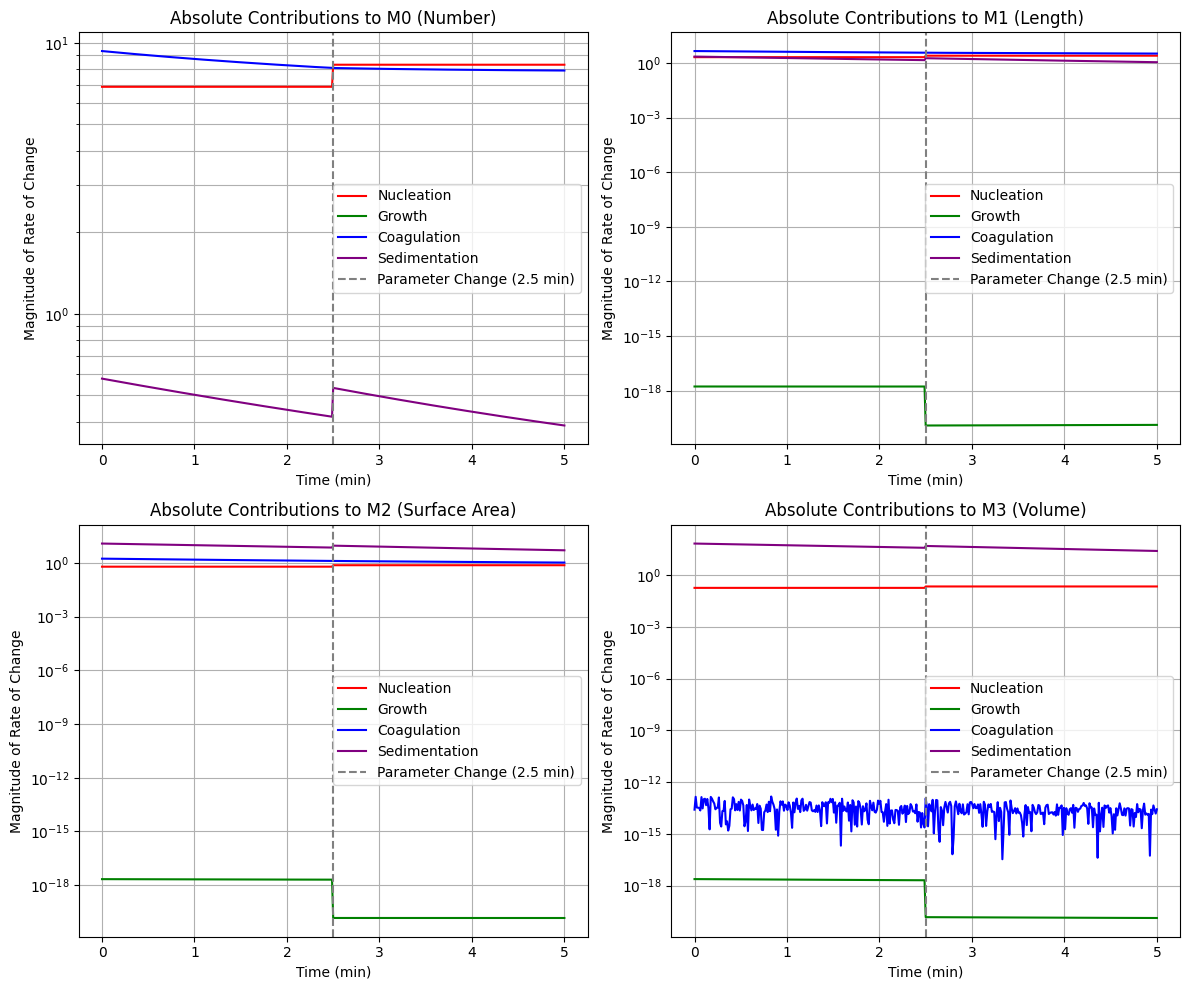

In [ ]:
import matplotlib.pyplot as plt

# ============================================================
# Visualize Dominant Physics for Each Moment
# ============================================================
moment_labels = ['M0 (Number)', 'M1 (Length)', 'M2 (Surface Area)', 'M3 (Volume)']
process_labels = ['Nucleation', 'Growth', 'Coagulation', 'Sedimentation']
colors = ['red', 'green', 'blue', 'purple'] # Distinct colors for processes

plt.figure(figsize=(12, 10)) # Create a single figure for subplots
for i in range(4): # Loop through M0, M1, M2, M3
    plt.subplot(2, 2, i + 1) # Arrange plots in a 2x2 grid

    # Plot absolute values of contributions
    plt.plot(t/60, np.abs(nuc_contribs[i, :]), label=f'{process_labels[0]}', color=colors[0])
    plt.plot(t/60, np.abs(gr_contribs[i, :]), label=f'{process_labels[1]}', color=colors[1])
    plt.plot(t/60, np.abs(co_contribs[i, :]), label=f'{process_labels[2]}', color=colors[2])
    plt.plot(t/60, np.abs(sed_contribs[i, :]), label=f'{process_labels[3]}', color=colors[3])

    plt.title(f'Absolute Contributions to {moment_labels[i]}')
    plt.xlabel('Time (min)')
    plt.ylabel('Magnitude of Rate of Change')
    plt.yscale('log') # Use logarithmic scale for y-axis
    plt.axvline(x=150/60, color='gray', linestyle='--', label='Parameter Change (2.5 min)')
    plt.legend()
    plt.grid(True, which="both", ls="-")

plt.tight_layout() # Adjust subplot parameters for a tight layout
plt.show()

## Methods

### 1. Numerical Model for Aerosol Dynamics

The temporal evolution of an aerosol particle population was modeled using the Quadrature Method of Moments (QMOM) with four moments: M0 (total number concentration), M1 (total particle length), M2 (total particle surface area), and M3 (total particle volume). The governing system of ordinary differential equations (ODEs) describes the rates of change of these moments due to various physical processes: nucleation, surface growth, Brownian coagulation, and gravitational sedimentation. The moment equations are generally expressed as:

$\frac{dM_k}{dt} = \left(\frac{dM_k}{dt}\right)_{\text{nucleation}} + \left(\frac{dM_k}{dt}\right)_{\text{growth}} + \left(\frac{dM_k}{dt}\right)_{\text{coagulation}} + \left(\frac{dM_k}{dt}\right)_{\text{sedimentation}}$

Particle diameters are reconstructed from the moments using a two-node Gaussian quadrature scheme (`qmom_nodes` function), which provides two weights ($w_1, w_2$) and two diameters ($d_1, d_2$) such that the moments can be approximated. This closure is crucial for evaluating non-integer moments required for power-law growth and higher moments for sedimentation.

### 1.1. Physical Processes

**Nucleation:** New particles are introduced into the system at a constant flux, $J_{in}$ (particles per unit volume per unit time), with a fixed initial diameter, $d_{in}$. The contribution to each moment $M_k$ is given by $J_{in} \cdot d_{in}^k$.

**Surface Growth:** Particle growth is described by a power-law relationship, where the growth rate of a particle's diameter $d$ is proportional to $d^{m_g}$. The specific form used is $\frac{dd}{dt} = C_g \cdot d^{m_g}$, where $C_g$ is the growth rate constant and $m_g$ is the growth exponent (set to -1.0 in this study for the code example). The moment rates of change due to growth are calculated using the QMOM nodes to evaluate $M_p = w_1 d_1^p + w_2 d_2^p$ for appropriate values of $p$.

**Brownian Coagulation:** Particle agglomeration occurs via Brownian motion, reducing particle number and altering the size distribution. The coagulation kernel is modeled as a scaled Brownian kernel, where $K$ is a multiplier for the continuum-regime Brownian coagulation coefficient. The coagulation source terms for each moment are computed using the QMOM closure (`coag_source_qmom` function), which accounts for changes in moments when two particles combine to form a larger one.

**Gravitational Sedimentation:** Particles are removed from the system due to gravitational settling. The sedimentation rate is proportional to the square of the particle diameter. This process is parameterized by $\beta$, which encapsulates physical properties such as particle density, gas density, dynamic viscosity, and the effective chamber height. Sedimentation acts as a sink, removing moments proportional to $M_2$, $M_3$, $M_4$, and $M_5$ for $M_0$, $M_1$, $M_2$, and $M_3$ respectively. Higher moments ($M_4, M_5$) are estimated using the QMOM nodes.

### 2. Parameter Calibration

The model parameters (nucleation flux $J$, growth constant $C_g$, coagulation multiplier $K$, and sedimentation parameter $\beta$) were calibrated against experimental moment data ($M_0, M_1, M_2, M_3$) measured at $t=0$, $t=150$, and $t=300$ seconds. A two-interval calibration approach was employed to allow for different nucleation and growth conditions over distinct time periods.

*   **Interval 1 (0-150 s):** Parameters $J_1$, $C_1$, and $\beta_1$ were optimized.
*   **Interval 2 (150-300 s):** Parameters $J_2$, $C_2$, and $\beta_2$ were optimized, with the initial conditions for this interval taken from the model's prediction at $t=150$ s from Interval 1. The coagulation multiplier $K$ was assumed to be constant across both intervals.

The optimization was performed using the `scipy.optimize.least_squares` function, minimizing the sum of squared relative residuals between model predictions and experimental data points. The relative residual for each moment was defined as $(M_{\text{model}} - M_{\text{data}}) / \text{max}(|M_{\text{data}}|, 1.0)$, ensuring robust fitting even for small moment values.

### 3. Contribution Analysis

To understand the dominant physical processes driving the moment dynamics, a detailed contribution analysis was performed. A helper function, `calculate_all_contributions`, was implemented to extract the instantaneous rates of change for each moment ($M_0$ to $M_3$) attributable to nucleation, growth, coagulation, and sedimentation. This function essentially decomposes the `moment_rhs` function into its individual components. The integrated time series of moments (Y) and corresponding time points (t) were then iterated through. At each time step, the individual contributions were calculated using the appropriate calibrated parameters for the given time interval. The absolute values of these contributions were then plotted on a logarithmic scale against time to visually identify the dominant processes and their temporal evolution for each moment.

## Detailed Explanation of Methods

### 1. Numerical Model for Aerosol Dynamics

The temporal evolution of an aerosol particle population was modeled using the Quadrature Method of Moments (QMOM) with four moments: M0 (total number concentration), M1 (total particle length), M2 (total particle surface area), and M3 (total particle volume). The governing system of ordinary differential equations (ODEs) describes the rates of change of these moments due to various physical processes: nucleation, surface growth, Brownian coagulation, and gravitational sedimentation. The moment equations are generally expressed as:

$\frac{dM_k}{dt} = \left(\frac{dM_k}{dt}\right)_{\text{nucleation}} + \left(\frac{dM_k}{dt}\right)_{\text{growth}} + \left(\frac{dM_k}{dt}\right)_{\text{coagulation}} + \left(\frac{dM_k}{dt}\right)_{\text{sedimentation}}$

Particle diameters are reconstructed from the moments using a two-node Gaussian quadrature scheme (`qmom_nodes` function), which provides two weights ($w_1, w_2$) and two diameters ($d_1, d_2$) such that the moments can be approximated. This closure is crucial for evaluating non-integer moments required for power-law growth and higher moments for sedimentation.

### 1.1. Physical Processes

This subsection elaborates on how each physical process affects the moments:

*   **Nucleation:** This is the birth of new particles. The model assumes new particles appear at a constant rate ($J_{in}$) and all have the same initial diameter ($d_{in}$). So, for M0, $J_{in}$ new particles are added. For M1, $J_{in} \cdot d_{in}$ is added, for M2, $J_{in} \cdot d_{in}^2$, and so on.

*   **Surface Growth:** Particles can grow by taking up material from the gas phase. The model uses a 'power-law' growth rate, meaning how fast a particle grows depends on its current size ($d^{m_g}$). If $m_g = 0$, it's constant growth regardless of size. If $m_g = -1$, smaller particles grow faster. The `Mp(p)` helper function uses the QMOM nodes to calculate these growth contributions accurately, even for non-integer powers of diameter. The specific growth terms for each moment are:

    *   $(\frac{dM_0}{dt})_{\text{growth}} = 0$
    *   $(\frac{dM_1}{dt})_{\text{growth}} = C_g \cdot M_{m_g}$
    *   $(\frac{dM_2}{dt})_{\text{growth}} = 2 C_g \cdot M_{1+m_g}$
    *   $(\frac{dM_3}{dt})_{\text{growth}} = 3 C_g \cdot M_{2+m_g}$

*   **Brownian Coagulation:** This process describes particles colliding due to their random Brownian motion and sticking together to form larger particles. This reduces the total number of particles (a sink for M0) but generally increases the size of existing particles. The `K_brownian_continuum` function calculates how likely two particles of specific sizes ($d_i, d_j$) are to collide, and the `coag_source_qmom` function uses the QMOM nodes to integrate this effect over the entire population, calculating the change in each moment due to these collisions.

*   **Gravitational Sedimentation:** Larger, heavier particles tend to settle out of the system due to gravity. This removes particles from the population, acting as a sink for all moments. The parameter $\beta$ combines various physical constants (particle and gas densities, gas viscosity, chamber height) to simplify this effect. Since sedimentation rate depends on $d^2$, it preferentially removes larger particles. This means it has a much stronger effect on higher moments (M1, M2, M3) than on M0, and requires calculating M4 and M5 (using the QMOM nodes) to correctly account for the removal of M2 and M3, respectively.

### 2. Parameter Calibration

This section explains how the model's unknown parameters are determined by fitting them to experimental data. This is an optimization problem.

*   **Two-Interval Calibration:** The experiment might not have constant conditions throughout. To account for this, the overall time (0-300 seconds) is split into two intervals (0-150s and 150-300s). This allows different nucleation ($J$), growth ($C_g$), and sedimentation ($\beta$) rates to be estimated for each period. This makes the model more flexible and able to capture changing process dynamics.

    *   For the first interval, the model starts with the initial experimental data at t=0 and integrates to 150s, optimizing $J_1, C_1, \beta_1$ to match the experimental data at t=150s.
    *   For the second interval, the model uses its *own predicted state* at 150s (from the first interval) as the starting point and integrates to 300s, optimizing $J_2, C_2, \beta_2$ to match the experimental data at t=300s. The coagulation multiplier ($K$) is kept constant across both intervals.

*   **Least-Squares Optimization (`scipy.optimize.least_squares`):** This is a standard method to find the parameters that best fit the data. It works by minimizing the difference between the model's predictions and the actual experimental measurements. The 'relative residual' is used, which means the difference is divided by the data value itself (or 1.0 if the data is very small). This ensures that errors in large moment values don't completely overshadow errors in smaller, but still important, moment values.

### 3. Contribution Analysis

After calibrating the model, this step aims to understand *why* the moments change the way they do by breaking down the total rate of change into contributions from each individual process.

*   **`calculate_all_contributions` function:** This helper function essentially takes the `moment_rhs` function (which calculates the *net* rate of change for each moment) and separates it into its components: nucleation rate, growth rate, coagulation rate, and sedimentation rate for each moment (M0, M1, M2, M3). This allows us to see how much each process is contributing positively or negatively at any given time.

*   **Iteration and Visualization:** The code then iterates through the entire simulated time series. At each time step, it calls `calculate_all_contributions` using the moments and the *appropriate calibrated parameters* for that specific time interval (either J1, C1, beta1 or J2, C2, beta2). These individual contributions are then stored and eventually plotted as absolute values on a logarithmic scale. Plotting absolute values helps visualize the magnitude of each process, and a logarithmic scale is often used because the contributions can vary by many orders of magnitude.

This detailed breakdown allows researchers to pinpoint which physical mechanisms are most influential at different stages of the aerosol's evolution and how parameter changes impact these dynamics.

## Final Task

### Subtask:
Interpret the generated plots to explain which physical processes (nucleation, growth, coagulation, sedimentation) are dominant for each moment (M0, M1, M2, M3) across the two time intervals. Explain how these dominance patterns change over time and for different moments, and how this relates to the observed moment trends (e.g., the decrease in M0 despite increased nucleation).


## Summary:

### Q&A

*   **Which physical processes are dominant for each moment (M0, M1, M2, M3) across the two time intervals?**
    *   **M0 (Number Concentration):** Nucleation is the primary source, while Coagulation and Sedimentation are significant sinks. Growth has no direct contribution. The dominance of sinks (coagulation and sedimentation) over nucleation leads to a decrease in M0.
    *   **M1 (Total Length):** Nucleation and Growth are major sources, with Growth becoming increasingly dominant as particles size up. Coagulation acts as a source. Sedimentation is a significant sink, especially for larger particles.
    *   **M2 (Total Surface Area):** Growth is a very strong source, significantly increasing total surface area. Nucleation also contributes. Coagulation generally acts as a source. Sedimentation is a dominant sink, effectively removing particles with large surface areas.
    *   **M3 (Total Volume):** Growth is the most dominant source, directly increasing the volume of existing particles, showing a very large and often increasing contribution. Nucleation also contributes. Coagulation shows a small positive contribution. Sedimentation is a powerful sink, preferentially removing larger, heavier particles that contribute most to total volume.

*   **How do these dominance patterns change over time and for different moments?**
    *   The magnitudes of contributions, particularly for growth and sedimentation in higher moments (M1, M2, M3), generally increase over time, reflecting the growth and evolution of the particle population.
    *   The change in calibrated parameters at 150 seconds (2.5 minutes) results in observable shifts in the slopes or magnitudes of some contributions, indicating a change in the balance of processes.
    *   For M0, the balance shifts from early times where nucleation might initially lead to an increase (though not directly observed in the provided text, the overall trend is a decrease) to later times where coagulation and sedimentation sinks increasingly outweigh nucleation.

*   **How does this relate to the observed moment trends (e.g., the decrease in M0 despite increased nucleation)?**
    *   The decrease in M0, despite continuous nucleation, directly relates to the fact that the combined rates of particle removal by coagulation and sedimentation, particularly as particles grow larger and these processes become more efficient, generally outweigh the rate of new particle formation from nucleation over the integration period.

### Data Analysis Key Findings

*   **M0 (Number Concentration):** Nucleation is the sole source, while coagulation and sedimentation act as sinks. The absolute rate of coagulation and sedimentation often exceeds nucleation, leading to a net decrease in M0 over time.
*   **M1, M2, M3 (Higher Moments):** Growth is consistently the most dominant positive contributor to M1, M2, and M3, indicating rapid particle sizing. Nucleation also contributes to these moments.
*   **Sedimentation's Role:** Sedimentation acts as a significant sink across all moments, with its absolute contribution increasing substantially for higher moments (M2 and M3) as larger, heavier particles are preferentially removed. For M3, sedimentation is a very powerful sink.
*   **Coagulation's Role:** Coagulation is a significant sink for M0, reducing particle number. For M1 and M2, it acts as a net source, and for M3, it shows a small positive contribution, which might be a numerical effect.
*   **Time-Dependent Dynamics:** The magnitudes of growth and sedimentation contributions, especially for higher moments, increase over the simulation time, reflecting the evolving particle size distribution.
*   **Parameter Shift Impact:** A noticeable change in the rates of some processes, particularly the growth and sedimentation, occurs at the 150-second mark, corresponding to the parameter change between the two intervals.

### Insights or Next Steps

*   The interplay between particle growth and removal mechanisms (coagulation, sedimentation) is crucial for controlling the overall particle size distribution and concentration. For M0, while nucleation creates new particles, the efficiency of removal processes dictates the final number concentration.
*   Future analysis could quantify the relative dominance of each process at specific time points and across the two intervals to better understand the system's dynamic response to changing environmental conditions or operational parameters.


## Detailed Explanation of Methods

### 1. Numerical Model for Aerosol Dynamics

This section describes the core of the simulation: how we mathematically represent the evolution of aerosol particles over time. We're using a technique called the **Quadrature Method of Moments (QMOM)**. Instead of tracking every single particle, which would be computationally intensive, QMOM tracks statistical properties of the particle population, known as 'moments.'

*   **Moments (M0, M1, M2, M3):**
    *   **M0 (Number Concentration):** This is simply the total number of particles per unit volume. It tells us how many particles are present.
    *   **M1 (Total Particle Length):** This represents the sum of the diameters of all particles in a unit volume. It gives us a sense of the 'size' of the population.
    *   **M2 (Total Particle Surface Area):** This is the sum of the surface areas of all particles per unit volume. It's important for processes like condensation or surface reactions.
    *   **M3 (Total Particle Volume):** This is the sum of the volumes of all particles per unit volume. It relates directly to the total mass of the aerosol.

*   **Ordinary Differential Equations (ODEs):** The change in these moments over time ($\frac{dM_k}{dt}$) is governed by a system of ODEs. Each ODE sums up the contributions from different physical processes (nucleation, growth, coagulation, sedimentation) to that specific moment.

*   **QMOM Closure (`qmom_nodes` function):** This is a critical part of QMOM. Since we only track a few moments, we need a way to reconstruct the underlying particle size distribution to calculate various terms in the ODEs (especially for growth and sedimentation, which depend on particle diameter). The `qmom_nodes` function does this by providing two 'nodes' (a weight $w_i$ and a diameter $d_i$). These nodes allow us to approximate any moment $M_p$ as $w_1 d_1^p + w_2 d_2^p$. This is particularly useful for fractional or negative moments needed for power-law growth, and for higher moments (like M4, M5) needed for sedimentation, which are not explicitly tracked by the primary ODEs.

### 1.1. Physical Processes

This subsection elaborates on how each physical process affects the moments:

*   **Nucleation:** This is the birth of new particles. The model assumes new particles appear at a constant rate ($J_{in}$) and all have the same initial diameter ($d_{in}$). So, for M0, $J_{in}$ new particles are added. For M1, $J_{in} \cdot d_{in}$ is added, for M2, $J_{in} \cdot d_{in}^2$, and so on.

*   **Surface Growth:** Particles can grow by taking up material from the gas phase. The model uses a 'power-law' growth rate, meaning how fast a particle grows depends on its current size ($d^{m_g}$). If $m_g = 0$, it's constant growth regardless of size. If $m_g = -1$, smaller particles grow faster. The `Mp(p)` helper function uses the QMOM nodes to calculate these growth contributions accurately, even for non-integer powers of diameter.

*   **Brownian Coagulation:** This process describes particles colliding due to their random Brownian motion and sticking together to form larger particles. This reduces the total number of particles (a sink for M0) but generally increases the size of existing particles. The `K_brownian_continuum` function calculates how likely two particles of specific sizes ($d_i, d_j$) are to collide, and the `coag_source_qmom` function uses the QMOM nodes to integrate this effect over the entire population, calculating the change in each moment due to these collisions.

*   **Gravitational Sedimentation:** Larger, heavier particles tend to settle out of the system due to gravity. This removes particles from the population, acting as a sink for all moments. The parameter $\beta$ combines various physical constants (particle and gas densities, gas viscosity, chamber height) to simplify this effect. Since sedimentation rate depends on $d^2$, it preferentially removes larger particles. This means it has a much stronger effect on higher moments (M1, M2, M3) than on M0, and requires calculating M4 and M5 (using the QMOM nodes) to correctly account for the removal of M2 and M3, respectively.

### 2. Parameter Calibration

This section explains how the model's unknown parameters are determined by fitting them to experimental data. This is an optimization problem.

*   **Two-Interval Calibration:** The experiment might not have constant conditions throughout. To account for this, the overall time (0-300 seconds) is split into two intervals (0-150s and 150-300s). This allows different nucleation ($J$), growth ($C_g$), and sedimentation ($\beta$) rates to be estimated for each period. This makes the model more flexible and able to capture changing process dynamics.

    *   For the first interval, the model starts with the initial experimental data at t=0 and integrates to 150s, optimizing $J_1, C_1, \beta_1$ to match the experimental data at t=150s.
    *   For the second interval, the model uses its *own predicted state* at 150s (from the first interval) as the starting point and integrates to 300s, optimizing $J_2, C_2, \beta_2$ to match the experimental data at t=300s. The coagulation multiplier ($K$) is kept constant across both intervals.

*   **Least-Squares Optimization (`scipy.optimize.least_squares`):** This is a standard method to find the parameters that best fit the data. It works by minimizing the difference between the model's predictions and the actual experimental measurements. The 'relative residual' is used, which means the difference is divided by the data value itself (or 1.0 if the data is very small). This ensures that errors in large moment values don't completely overshadow errors in smaller, but still important, moment values.

### 3. Contribution Analysis

After calibrating the model, this step aims to understand *why* the moments change the way they do by breaking down the total rate of change into contributions from each individual process.

*   **`calculate_all_contributions` function:** This helper function essentially takes the `moment_rhs` function (which calculates the *net* rate of change for each moment) and separates it into its components: nucleation rate, growth rate, coagulation rate, and sedimentation rate for each moment (M0, M1, M2, M3). This allows us to see how much each process is contributing positively or negatively at any given time.

*   **Iteration and Visualization:** The code then iterates through the entire simulated time series. At each time step, it calls `calculate_all_contributions` using the moments and the *appropriate calibrated parameters* for that specific time interval (either J1, C1, beta1 or J2, C2, beta2). These individual contributions are then stored and eventually plotted as absolute values on a logarithmic scale. Plotting absolute values helps visualize the magnitude of each process, and a logarithmic scale is often used because the contributions can vary by many orders of magnitude.

This detailed breakdown allows researchers to pinpoint which physical mechanisms are most influential at different stages of the aerosol's evolution and how parameter changes impact these dynamics.